# Land Cover Classification with Python #

This script purpose is to do land cover classification solely using Python

I made it to challenge myself that it is possible to do the same approach as in Google Earth Engine using open source solution

I used multiple library for this script such as GeoPandas and pandas to load the vector file/database and plot it, Rasterio to load and handle raster data, Scikit-learn to do machine learning, Matplotlib of course to plot, Numpy obviously for raster/array manipulation, PIL for showing raster data, Scikit-image for image segmentation, and SciPy for statistics analysis

Overall, it is much harder to do than in Google Earth Engine but it is a good approach since we are using open source solution which don't need license

You can use this script just don't forget to credit me

Created by Ramadhan

[Email](ramiqcom@gmail.com)
[LinkedIn](https://linkedin.com/in/ramiqcom)
[GitHub](https://github.com/ramiqcom)
[Youtube](https://youtube.com/@ramiqcom)

In [97]:
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import rasterio as rio
from rasterio.enums import Resampling
import json
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from PIL import ImageColor
import skimage as ski
from skimage.exposure import rescale_intensity
import scipy
from rasterio.features import shapes

## Data Preparation ##

This is where you supposed to put your file location so that it can be loaded to the script

In [ ]:
# Location of data
lc_dir = '../../data/lc/lc.json'
sample_dir = "Sample_LC_v1.geojson"
palsar_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Palsar_Kerinci_2023_v1.tif"
landsat_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Landsat_Kerinci_2023_v1.tif"

### Preparing land cover values parameter ###
This section is where you can adjust palette, values, and label of your land cover data

In [139]:
# Load Land Cover Parameter
lc = json.load(open(lc_dir))
lc_df = pd.DataFrame(lc)
lc_df["values_normalize"] = lc_df.index + 1
lc_df["palette"] = "#" + lc_df["palette"]

# Mapping from old to new values
values = lc_df["values"].to_list()
values_norm = lc_df["values_normalize"].to_list()
palette = lc_df["palette"].to_list()
labels = lc_df["label"].to_list()
dict_values = {}
dict_label = {}
dict_palette = {}
dict_palette_hex = {}
for x in range(0, len(values)):
    dict_values[values[x]] = values_norm[x]
    dict_label[values_norm[x]] = labels[x]
    dict_palette[values_norm[x]] = ImageColor.getrgb(palette[x])
    dict_palette_hex[values_norm[x]] = palette[x]

# Create colormap from values and palette
cmap = ListedColormap(palette)

# Patches legend
patches = [
    mpatches.Patch(color=palette[i], label=labels[i]) for i in range(len(values))
]
legend = {
    "handles": patches,
    "bbox_to_anchor": (1.05, 1),
    "loc": 2,
    "borderaxespad": 0.0,
}

lc_df

,palette,values,label,values_normalize
0,#006400,2001,Primary dryland forest,1
1,#228B22,2002,Secondary dryland forest,2
2,#4B0082,2004,Primary mangrove forest,3
3,#808000,2005,Primary swamp forest,4
4,#32CD32,2006,Plantation forest,5
5,#90EE90,2007,Dry shrub,6
6,#FF4500,2010,Estate crop,7
7,#F08080,2012,Settlement,8
8,#D2B48C,2014,Bare ground,9
9,#ADFF2F,3000,Savanna and grasses,10


### Loading Sample Data ###
From the location of the sample from the previous chapter, it is loaded and shown so that you can check the distribution of your sample and its type

(14029, 5)


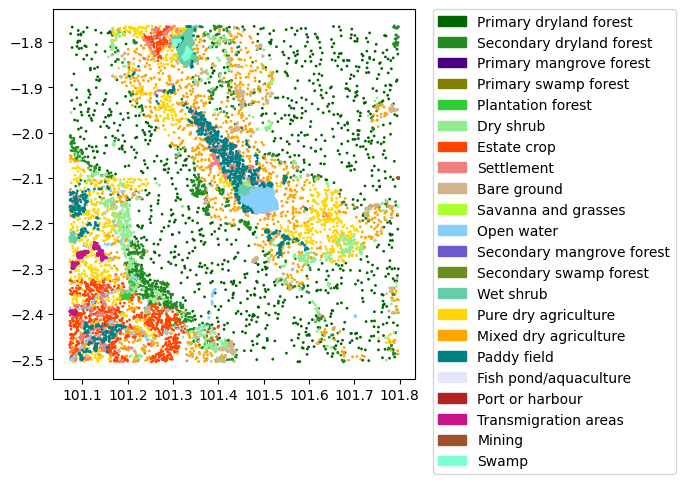

In [143]:
# Load sample
sample = gpd.read_file(sample_dir)
sample["value"] = sample["lc"].map(dict_values)
sample["label"] = sample["value"].map(dict_label)

# Plot sample
sample.plot(column="value", cmap=cmap, markersize=1)
plt.legend(**legend)

# Sample with extract
sample_extract = sample.copy()
coords = [
    (x, y) for x, y in zip(sample_extract["geometry"].x, sample_extract["geometry"].y)
]
print(sample_extract.shape)

### Loading Landsat Data ###
In this part, the Landsat image will be loaded into the script

You might need to change a thing or two if you are using another type of data

In [10]:
# Load landsat image
landsat = rio.open(landsat_dir)
landsat_image = landsat.read() / 1e4

### Showing and Extract Landsat Raster Values ###
This part is where we can see how the Landsat image look alike.

You should adjust which band to use and the scale min max value to show your data

This part also show you how we sample the value of pixel in the Landsat with our sample

,id,lc,geometry,value,label,B1,B2,B3,B4,B5,B6,B7,B9
0,0,2001,POINT (101.67155 -1.86099),1,Primary dryland forest,0.0091,0.0136,0.0321,0.0205,0.2243,0.0994,0.0408,0.0019
1,1,2001,POINT (101.43871 -2.23694),1,Primary dryland forest,0.0101,0.0159,0.0439,0.0292,0.3572,0.1479,0.0560,0.0027
2,2,2001,POINT (101.49341 -1.77152),1,Primary dryland forest,0.0205,0.0223,0.0389,0.0273,0.2772,0.1287,0.0554,0.0033
3,3,2001,POINT (101.75132 -2.02161),1,Primary dryland forest,0.0058,0.0133,0.0385,0.0247,0.2979,0.1405,0.0579,0.0027
4,4,2001,POINT (101.1242 -1.96125),1,Primary dryland forest,0.0174,0.0209,0.0400,0.0252,0.3285,0.1337,0.0543,0.0024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14024,14024,50011,POINT (101.32983 -1.83297),22,Swamp,0.0187,0.0235,0.0419,0.0425,0.1372,0.1336,0.0820,0.0026
14025,14025,50011,POINT (101.33306 -1.82461),22,Swamp,0.0205,0.0240,0.0407,0.0496,0.1509,0.1315,0.0788,0.0027
14026,14026,50011,POINT (101.33064 -1.8362),22,Swamp,0.0239,0.0278,0.0546,0.0443,0.2668,0.1430,0.0719,0.0023
14027,14027,50011,POINT (101.30207 -1.80063),22,Swamp,0.0315,0.0407,0.0621,0.0588,0.2338,0.1386,0.0839,0.0031


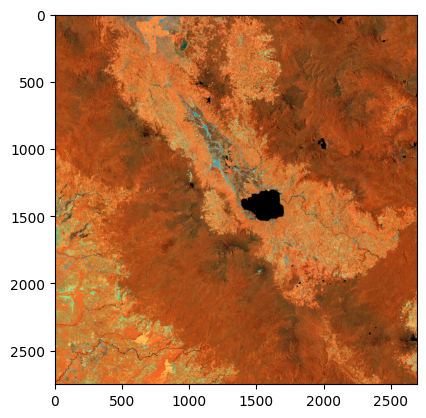

In [76]:
# False color composite
out_range = (0, 1)
red = rescale_intensity(landsat_image[4], in_range=(0.1, 0.4), out_range=out_range)
green = rescale_intensity(landsat_image[5], in_range=(0.05, 0.3), out_range=out_range)
blue = rescale_intensity(landsat_image[6], in_range=(0.025, 0.25), out_range=out_range)
arr_image = np.stack(
    [red, green, blue]
).T
composite = np.rot90(np.flip(arr_image, 1), 1)

# Plot landsat image
plt.imshow(composite)

# Extract raster value
landsat_extract = np.stack(
    [x for x in landsat.sample(coords)]
) / 1e4
sample_extract[["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B9"]] = landsat_extract
sample_extract

### PALSAR data load ###

Same like Landsat but for PALSAR data

I am using PALSAR because it is good to detect built up area

PALSAR has a different scale than Landsat therefore when reading the data as array, I resample it so that it has the same array shape with Landsat

In [26]:
# Load palsar image
palsar = rio.open(palsar_dir)
palsar_image = palsar.read(
    out_shape=(palsar.count, landsat_image.shape[1], landsat_image.shape[2]),
    resampling=Resampling.bilinear,
) / 1e3

#### Show and Extract PALSAR Raster ###

Also the same as Landsat but using PALSAR

For PALSAR I only use band HH and HV

,id,lc,geometry,value,label,B1,B2,B3,B4,B5,B6,B7,B9,HH,HV
0,0,2001,POINT (101.67155 -1.86099),1,Primary dryland forest,0.0091,0.0136,0.0321,0.0205,0.2243,0.0994,0.0408,0.0019,-7.608,-11.281
1,1,2001,POINT (101.43871 -2.23694),1,Primary dryland forest,0.0101,0.0159,0.0439,0.0292,0.3572,0.1479,0.0560,0.0027,-7.931,-11.993
2,2,2001,POINT (101.49341 -1.77152),1,Primary dryland forest,0.0205,0.0223,0.0389,0.0273,0.2772,0.1287,0.0554,0.0033,-7.901,-11.999
3,3,2001,POINT (101.75132 -2.02161),1,Primary dryland forest,0.0058,0.0133,0.0385,0.0247,0.2979,0.1405,0.0579,0.0027,-7.223,-11.135
4,4,2001,POINT (101.1242 -1.96125),1,Primary dryland forest,0.0174,0.0209,0.0400,0.0252,0.3285,0.1337,0.0543,0.0024,-8.136,-12.624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14024,14024,50011,POINT (101.32983 -1.83297),22,Swamp,0.0187,0.0235,0.0419,0.0425,0.1372,0.1336,0.0820,0.0026,-12.472,-19.294
14025,14025,50011,POINT (101.33306 -1.82461),22,Swamp,0.0205,0.0240,0.0407,0.0496,0.1509,0.1315,0.0788,0.0027,-11.963,-19.554
14026,14026,50011,POINT (101.33064 -1.8362),22,Swamp,0.0239,0.0278,0.0546,0.0443,0.2668,0.1430,0.0719,0.0023,-9.416,-15.761
14027,14027,50011,POINT (101.30207 -1.80063),22,Swamp,0.0315,0.0407,0.0621,0.0588,0.2338,0.1386,0.0839,0.0031,-10.746,-18.832


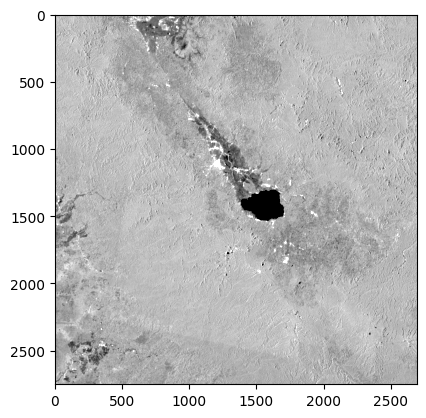

In [77]:
# Plot palsar image
plt.imshow(palsar_image[0], cmap="gray", vmin=-15, vmax=-5)

# Extract raster value
palsar_extract = np.stack([x for x in palsar.sample(coords)]) / 1e3
sample_extract[["HH", "HV"]] = palsar_extract
sample_extract

### Sample Split ###
In here I split the extracted sample as train and test so that I could assess the model performance

In [78]:
# Split sample to train and test
seeds = 2
train, test = train_test_split(sample_extract, train_size=0.7, random_state=seeds)
print(f'Train size: {len(train)}\nTest size: {len(test)}')

Train size: 9820
Test size: 4209


## Land Cover Modelling ##

To predict the land cover I am using only 6 bands of Landsat and 2 bands of PALSAR

I use Random Forest because it is very flexible and fast for land cover classification

In [ ]:
# Make random forest model
predictors = ["B2", "B3", 'B4', 'B5', 'B6', 'B7', 'HH', 'HV']
model = RandomForestClassifier(100)
model.fit(
    train[predictors],
    train["value"]
)

RandomForestClassifier()

### Model Assessment ###
After the model is trained, I apply that model to the test data

We will generate Confusion Matrix and Classification report on this part

              precision    recall  f1-score   support

           1       0.53      0.73      0.62       298
           2       0.42      0.42      0.42       309
           5       0.52      0.74      0.61       322
           6       0.24      0.14      0.18       293
           7       0.52      0.62      0.57       280
           8       0.60      0.57      0.59       303
           9       0.40      0.34      0.37       321
          11       0.96      0.88      0.92       295
          14       0.58      0.62      0.60       303
          15       0.29      0.20      0.24       291
          16       0.26      0.22      0.24       289
          17       0.64      0.66      0.65       297
          20       0.71      0.75      0.73       308
          21       0.33      0.14      0.20         7
          22       0.81      0.84      0.83       293

    accuracy                           0.55      4209
   macro avg       0.52      0.52      0.52      4209
weighted avg       0.54   

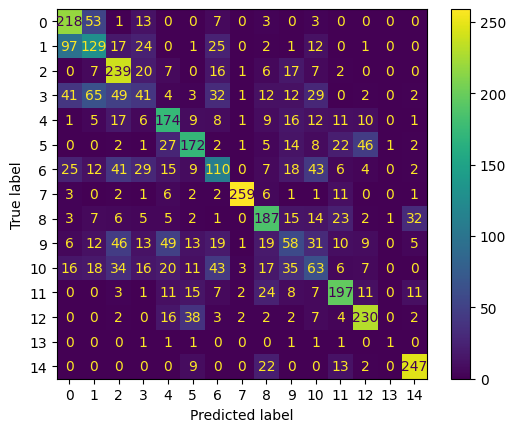

In [80]:
# Test model
test_apply = model.predict(test[predictors])

# Confusion matrix
cm = confusion_matrix(test['value'], test_apply)
display = ConfusionMatrixDisplay(cm)
display.plot()

# Report
report = classification_report(test['value'], test_apply)
print(report)

### Apply the Model to the Image ###

If the model is satisfactory, this part will show you how to apply the model to the Landsat and Palsar image to get the Land Cover Map

The result will also be shown

In [144]:
# Load image
combine_image = np.concatenate((landsat_image, palsar_image), 0)
image_transpose = combine_image.T
transpose_shape = image_transpose.shape
table_image = pd.DataFrame(
    image_transpose.reshape(-1, transpose_shape[2]),
    columns=["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B9", "HH", "HV"],
)
table_image

,B1,B2,B3,B4,B5,B6,B7,B9,HH,HV
0,0.0151,0.0165,0.0329,0.0213,0.2570,0.1103,0.0428,0.0023,-7.973,-12.063
1,0.0166,0.0184,0.0335,0.0215,0.2700,0.1119,0.0458,0.0025,-8.477,-12.280
2,0.0188,0.0198,0.0384,0.0216,0.3084,0.1288,0.0518,0.0026,-8.904,-12.676
3,0.0204,0.0221,0.0420,0.0241,0.3381,0.1348,0.0528,0.0025,-8.938,-13.058
4,0.0210,0.0231,0.0476,0.0274,0.3625,0.1518,0.0588,0.0024,-8.600,-13.174
...,...,...,...,...,...,...,...,...,...,...
7405687,0.0098,0.0139,0.0331,0.0209,0.2861,0.1183,0.0460,0.0026,-7.839,-11.874
7405688,0.0091,0.0137,0.0331,0.0202,0.2860,0.1191,0.0452,0.0027,-7.465,-11.422
7405689,0.0091,0.0136,0.0337,0.0208,0.2934,0.1197,0.0465,0.0027,-7.270,-11.149
7405690,0.0107,0.0146,0.0353,0.0207,0.2875,0.1156,0.0434,0.0027,-6.970,-11.184


In [82]:
# Predict table image
prediction = model.predict(table_image[predictors])
prediction

array([1, 1, 1, ..., 1, 1, 1])

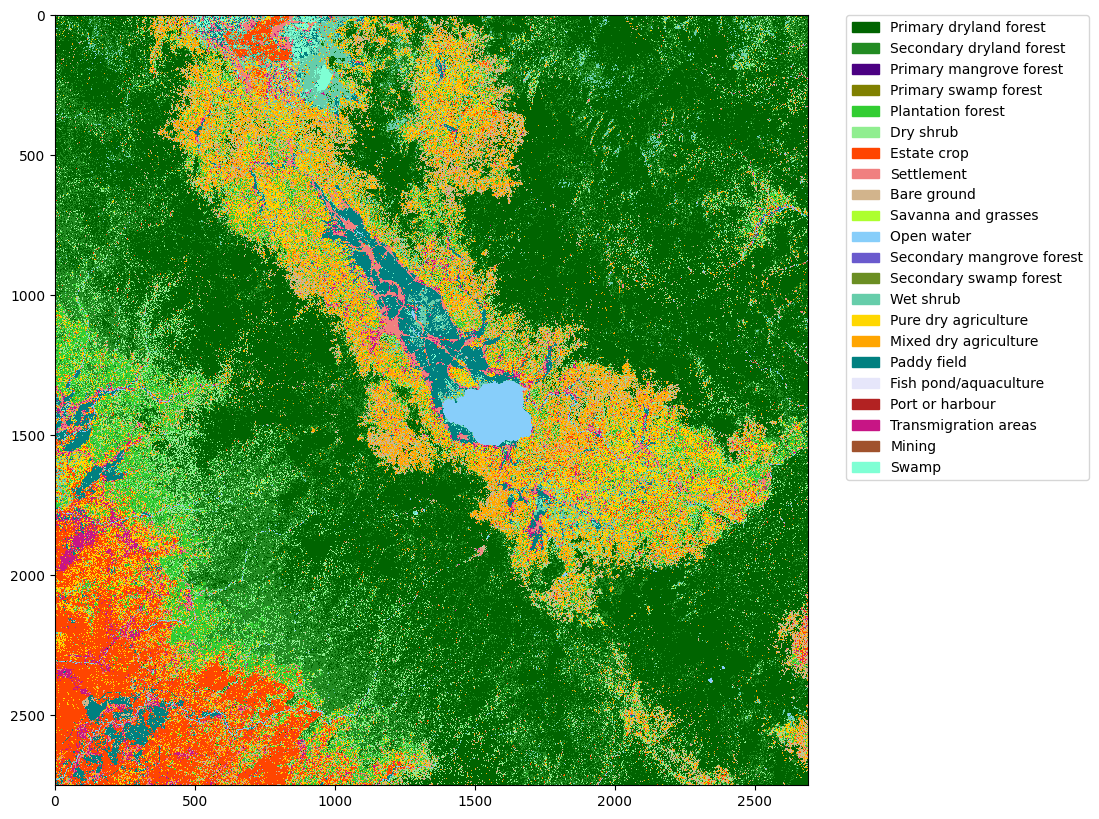

In [83]:
# Prediction to image again
prediction_image = np.rot90(np.flip(prediction.reshape(transpose_shape[0], transpose_shape[1]), 1), 1)

# Show to plot
plt.figure(figsize=(10, 10))
plt.imshow(prediction_image, cmap=cmap, interpolation="nearest")
plt.legend(**legend)

### Saving the Result ###

If the result is good enough, you can saved it to your local drive using this script as GeoTIFF data

This data can be used for other analysis

Or if you were not satisfied, there are the next steps that might be useful

In [ ]:
# Save image to geotiff
output = rio.open(
    "result/LULC.tif",
    "w",
    "COG",
    count=1,
    width=prediction_image.shape[1],
    height=prediction_image.shape[0],
    crs=landsat.crs,
    transform=landsat.transform,
    dtype="uint8",
    nodata=0,
    compress="lzw",
    resampling="mode",
    tiled=True,
)
output.write_colormap(1, dict_palette)
output.write(prediction_image, 1)
output.close()

## Image Segmentation ##

Sometime the result of land cover classification too many salt and pepper effect

This section will show you how to create a segmented land cover where this affect is dismissed

We will generate a segmentation using SLIC algorithms then used it to calculate zonal statistics per segment in the land cover data we have generated

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


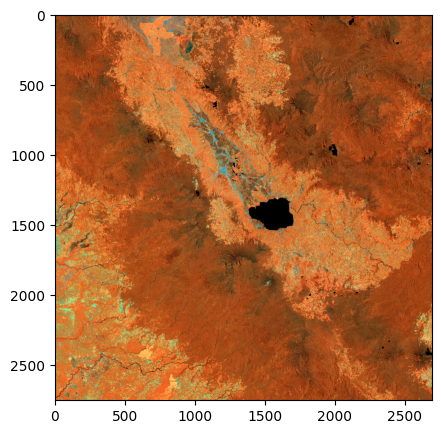

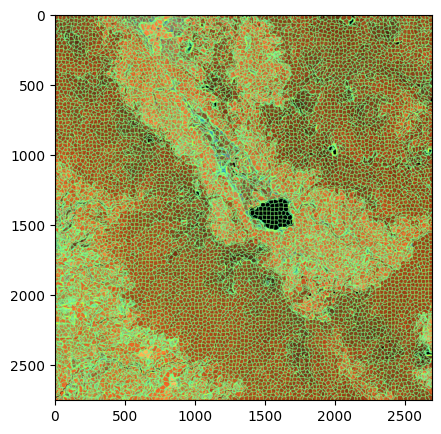

In [93]:
# Image segmentation

# Do uniform filter to composite image
seed_image = composite
plt.figure(figsize=(5, 5))
plt.imshow(seed_image)

# Segmentation
segment = ski.segmentation.slic(
    seed_image, n_segments=10000, compactness=5, sigma=5
)
plt.figure(figsize=(5, 5))
plt.imshow(ski.segmentation.mark_boundaries(composite, segment, outline_color=(0, 255, 255)))

### Calculating Mode of Land Cover Per Segment ###

After the segment is created, each segment will be used to calculate the mode of land cover that overlayed it

Then show the result just like the previous non segmented one

In [94]:
# Get the mode of each segment
segment_unique = np.unique(segment)
lc_segment = segment.copy()
for x in segment_unique:
    lc_segment[segment == x] = scipy.stats.mode(prediction_image[segment == x]).mode
lc_segment

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [7, 7, 7, ..., 1, 1, 1],
       [7, 7, 7, ..., 1, 1, 1],
       [7, 7, 7, ..., 1, 1, 1]])

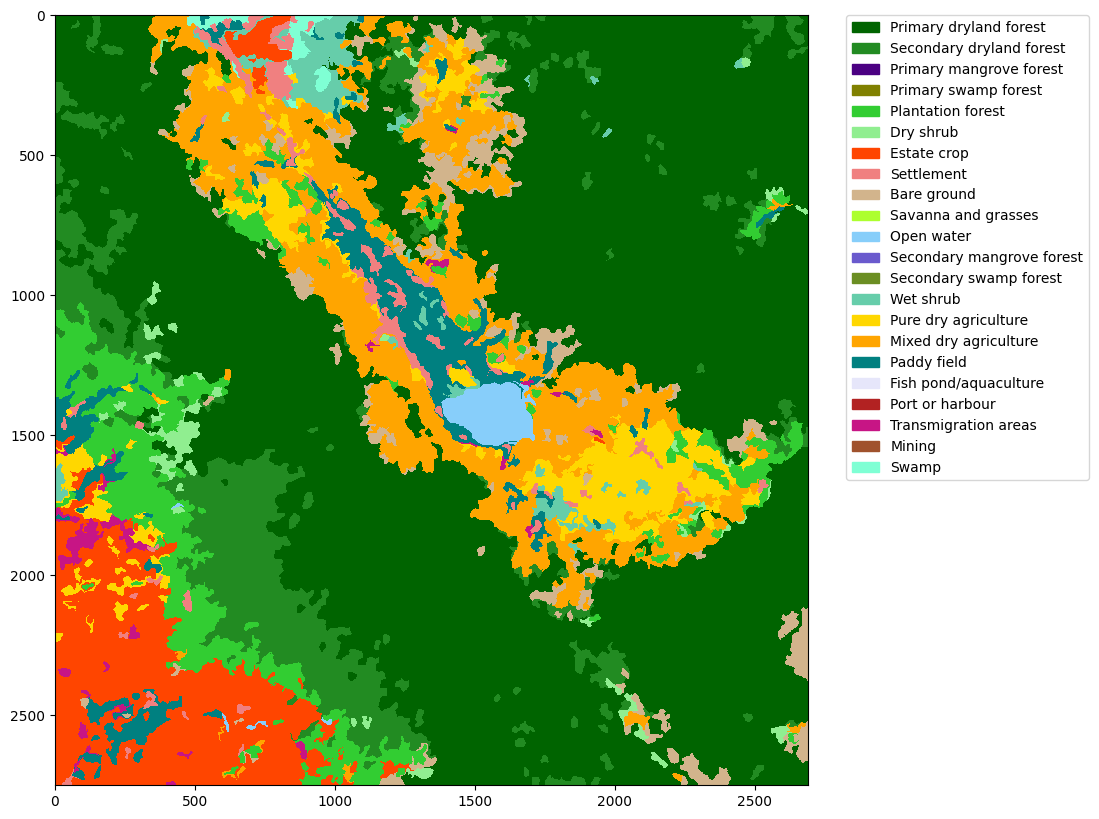

In [95]:
# Show to plot the segmented LC
plt.figure(figsize=(10, 10))
plt.imshow(lc_segment, cmap=cmap, interpolation="nearest")
plt.legend(**legend)

### Save the Segmented Land Cover ###

If the result is good, you can save the land cover as geotiff just like before

In [ ]:
# Save image to geotiff
output = rio.open(
    "result/LULC_Segment.tif",
    "w",
    "COG",
    count=1,
    width=lc_segment.shape[1],
    height=lc_segment.shape[0],
    crs=landsat.crs,
    transform=landsat.transform,
    dtype="uint8",
    nodata=0,
    compress="lzw",
    resampling="mode",
    tiled=True,
)
output.write_colormap(1, dict_palette)
output.write(lc_segment, 1)
output.close()

## Bonus: Convert it to Shapefile ##

If you want the result as shapefile, we could trace it using Rasterio Features module

And saved it as shapefile in your local drive

c:\Users\ramiq\Learning\lc-classification-python\.venv\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


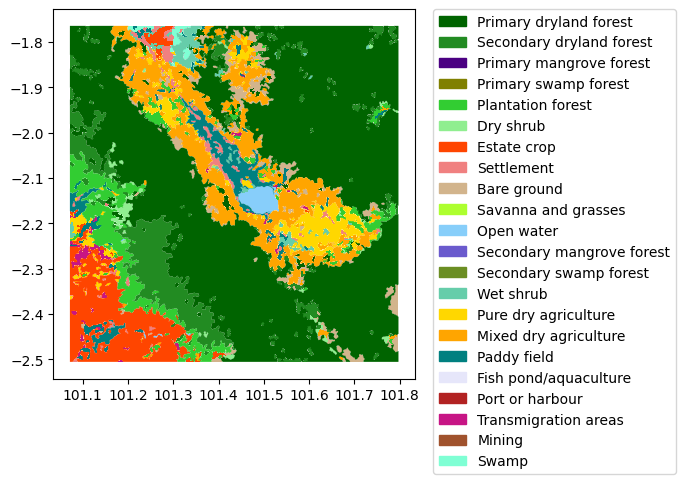

In [141]:
# Convert raster to shapefile
lc_vector = [{ "type": "Feature", "properties": { "lc": x[1] }, "geometry": x[0] } for x in shapes(lc_segment.astype('uint8'), transform=landsat.transform)]
lc_vector = json.dumps({
    "type": "FeatureCollection",
	"properties": {},
	"features": lc_vector
})

# Read as geodataframe
lc_df = gpd.read_file(lc_vector, driver='GeoJSON')

# Plot it
lc_df.plot(column="lc", cmap=cmap)
plt.legend(**legend)

### Save the Shapefile ###

In [ ]:
# Add another column such as palette and label
lc_df["palette"] = lc_df["lc"].map(dict_palette_hex)
lc_df["label"] = lc_df["lc"].map(dict_label)

# Save the file
lc_df.to_file("result/LULC_Shapefile.shp")